# Proyecto Medidas II - Medicion de THD

## Objetivo

El objetivo principal de este informe es presentar los resultados obtenidos en las mediciones del Distorsión Armónica Total (THD, por sus siglas en inglés) en la señal obtenida por el microcontrolador y amplificador en el contexto del medidor y controlador de loudness desarrollado.
Se busca obtener el resultado de cuanta es la distorcion que provoca el micrcontrolador y el amplificador en el sistema, para lo cual se obtuvieron las señales antes del ingreso al amplificador de audio y luego del mismo.

## Esquema de medicion

Debido a que la comunicacion entre el ESP32 y el amplificador es del tipo digital es necesario capturar la señal con un analizador logico. Por otro lado el amplificador cuenta con una salida tipo bridge o diferencial con lo cual es necesario tomar la señal de ambos extremos del parlante.
Para las mediciones realizadas se adopto el siguiente esquema de conexion

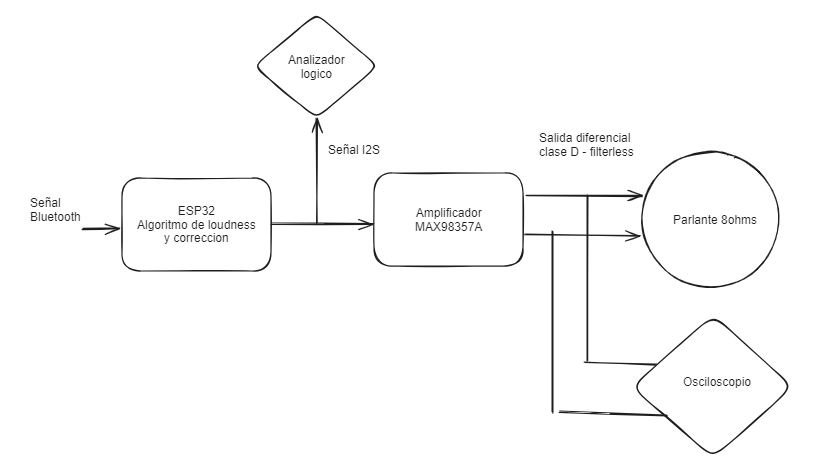

## Señales de prueba

Para las señales de prueba se utilizaron tonos puros senoidales para 3 frecuencias:

- Señal 1: 500Hz
- Señal 2: 1000Hz
- Señal 3: 10000Hz

Luego para cada una de estas señales se obtuvieron las mediciones para 3 niveles de loudness:

- Loudness 1: 70LKFS
- Loudness 2: 60LKFS
- Loudness 3: 50LKFS

Estos tonos fueron generados por medio de una aplicacion movil para poder enviar por bluetooth la señal al microcontrolador.

## Instrumentos y hardware utilizado

Se utilizaron los siguientes instrumentos de medicion:

- Analizador logico Duaitek LA2408
- Osciloscopio Rigol MSO-X 3024A

Hardaware utilizado:

- ESP32 
- Amplificador I2S MAX98357
- Placa de conexion

## Amplificador

Para la señal de entrada del amplificador se utiliza el protocolo de comunicacion I2S con una tasa de muestreo de 44.1Khz y datos de 16bits de profundidad. Se transmite la informacion de ambos canales, sin embargo en la configuracion utilizada el dispositivo unicamente toma los datos del canal izquierdo.
El amplificador utilizado es del tipo clase D con una salida tipo bridge y sin filtrar. El mismo aprovecha del filtrado que realiza la propia impedancia del parlante y el filtrado del oido humano para poder eliminar la frecuencia de portadora que utiliza el dispositivo para modular la señal. La señal moduladora se encuentra en los 300Khz con una variacion de +-20KHz.


# Mediciones Señal ESP32 (salida del microcontrolador)

A continuacion se muestran las señales medidas para cada caso en la salida del ESP32. Como ambos canales tienen la misma informacion de entrada solo se muestran los resultado del canal izquierdo.

In [69]:
import numpy as np
from scipy.signal import lfilter,flattop,butter
import matplotlib.pyplot as plt
from math import floor
import pandas as pd

def get_max(señal,eje):
    indice_max = np.argmax(señal)
    return (señal[indice_max], eje[indice_max])

# Funcion de calculo de THD
def get_THD(test_signal):
    yf = np.fft.fft(test_signal)
    yf = yf[1:floor(len(yf)/2)]
    yf = np.abs(yf) # Obtengo el modulo

    # Calculo el indice donde esta la frecuencia fundamental
    f0_index = np.argmax(yf)

    # Armo vector con los indices de los armonicos
    harmonics__index = np.arange(f0_index,len(yf)-1,f0_index)

    # Creo vector con valores de los harmonicos
    harmonics_values = yf[harmonics__index]

    # Calculo thd
    thd = np.sqrt(np.sum(harmonics_values[1:]**2))/harmonics_values[0]
    
    return thd


def plot_muestras(channel0, channel1, time_axis,title):
    # Genera un plot con ambas señales
    plt.figure(figsize=(8,6))
    plt.plot(time_axis, channel0, label='Channel 0')
    
    if channel1 is not None:
        plt.plot(time_axis, channel1, label='Channel 1')

    # Etiquetas y título del gráfico
    plt.xlabel('Tiempo [S]')
    plt.ylabel('Volts [V]')
    plt.title(title)
    plt.legend()

    # Muestra el gráfico
    plt.show()
    
# Funcion que permite Plotear la FFT del vector
def plot_FFT(voltages, times, plot_title, range = None):
    # Aplicar la ventana flat top
    flat_top_window = flattop(len(voltages))
    voltages_windowed = voltages * flat_top_window

    # Calcular la FFT
    fft_result = np.fft.fft(voltages_windowed)
    fft_result_shifted = np.fft.fftshift(fft_result)  # Centrar las frecuencias

    # Obtener el eje de frecuencias centrado
    fft_freq = np.fft.fftfreq(len(times), times[1] - times[0])
    fft_freq_shifted = np.fft.fftshift(fft_freq)

    # Obtener el módulo de la FFT
    fft_module = np.abs(fft_result_shifted)

    # Plotear la FFT (eliminar el espectro repetido)
    plt.figure(figsize=(10, 6))

    modulo = (20 * np.log10(fft_module[len(fft_module)//2:]))
    ejeFreq = fft_freq_shifted[len(fft_freq_shifted)//2:]

    if range is not None:
        ejeFreq = [t for t in ejeFreq if t <= range]
        
    plt.plot(ejeFreq, modulo[:len(ejeFreq)])
    plt.title(plot_title)
    plt.xlabel("Frecuencia (Hz)")
    plt.ylabel("Amplitud (dB)")
    plt.grid(True)
    plt.show()
    
    # Paso 6: Obtengo la frecuencia de la señal levantada
    max_db,freq = get_max(modulo,ejeFreq)
    print(f"El pico de la FFT se encuentra en: {round(freq,3)}Hz con un valor de {round(max_db,3)}dB")


def butter_lowpass_filter(data, cutoff_freq, sample_rate, order=4):
    nyquist = 0.5 * sample_rate
    normal_cutoff = cutoff_freq / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = lfilter(b, a, data)
    return filtered_data

def decimal_to_binary(decimal_num):
    binary_str = bin(decimal_num)[2:]
    binary_str = binary_str.zfill(16)
    return binary_str


def binary_to_decimal(dataBin):
    
    data = []
    
    for i in range(16):
        if(dataBin[i]=="0"):
            data.append(0)
        else:
            data.append(1)
    
    numero_decimal = int(''.join(map(str, data[1:])), 2)
    
    if data[0] == 1:
        numero_decimal = -((1 << (len(data) - 1)) - numero_decimal)

    return numero_decimal

In [109]:

def analizar_señales_analizador_logico(nombre_archivo):
    
    # Paso 1: Lee el archivo CSV
    df = pd.read_csv(nombre_archivo)

    # Paso 2: Filtra los datos del canal 1 y convierte de hexadecimal a decimal
    channel0 = df[df['channel'] == '0x0000000000000000']['data'].apply(lambda x: int(x, 16)).values

    # Paso 3: Filtra los datos del canal 2 y convierte de hexadecimal a decimal
    channel1 = df[df['channel'] == '0x0000000000000001']['data'].apply(lambda x: int(x, 16)).values

    # Paso 4: Ajusto datos por si uno tiene más cantidad que el otro
    largo = 0
    if len(channel0) < len(channel1):
        largo = len(channel0)
        channel1 = channel1[:largo]

    elif len(channel1) < len(channel0):
        largo = len(channel1)
        channel0 = channel0[:largo]
    else:
        largo = len(channel1)

    # Paso 5: Convierto de Decimal a BinCA2 y luego a decimal
    for i in range(largo):
        channel0[i] = binary_to_decimal( decimal_to_binary(channel0[i]) )
        channel1[i] = binary_to_decimal( decimal_to_binary(channel1[i]) )


    # Paso 6: Genero eje de tiempos 20mS
    sampling_rate = 44100
    num_samples = 0.02 * sampling_rate
    time_axis = np.arange(0, num_samples) * (1 / sampling_rate)
    max_value = 2**16 / 2 # maximo valor binario
    
    # Paso 7: Elimino 2ms del comienzo para evitar transitorios de medicion
    sample_start =int( 2e-3 * sampling_rate)
    channel1 = channel1[sample_start:]
    
    # Paso 8: Filtro señal para tener mismas condiciones que la medicion del OSC
    channel1 = np.array(channel1[:len(time_axis)]) * 5/max_value
    channel1 = butter_lowpass_filter(channel1, 20000, sampling_rate)

    # Paso 9: Ploteo
    plot_muestras(channel1, None, time_axis, "Señales canal Izquiero y Derecho")

    # Paso 10: Ploteo FFT
    plot_FFT(channel1,time_axis,"Señal FFT")

    # Paso 11: Calculo THD
    THD1 = get_THD(channel1)
    print(f"El THD del canal 1 es de {THD1*100}%")

In [112]:
archivos = ["./Mediciones-AnalizadorLogico/500hz/500hz_70lkfs.csv","./Mediciones-AnalizadorLogico/500hz/500hz_60lkfs.csv","./Mediciones-AnalizadorLogico/500hz/500hz_50lkfs.csv"]
nombre_medicion = ["Señal 500Hz - 70LKFS","Señal 500Hz - 60LKFS","Señal 500Hz - 50LKFS"]
for this_archivo,this_nombre in zip(archivos,nombre_medicion):
    print(f"\n{this_nombre}")
    analizar_señales_analizador_logico(this_archivo)



Señal 500Hz - 70LKFS


FileNotFoundError: [Errno 2] No such file or directory: './Mediciones-AnalizadorLogico/500hz/500hz_70lkfs.csv'


Señal 1000 - 70LKFS


C:\Users\guido\AppData\Local\Temp\ipykernel_14200\936099974.py:4: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(nombre_archivo)


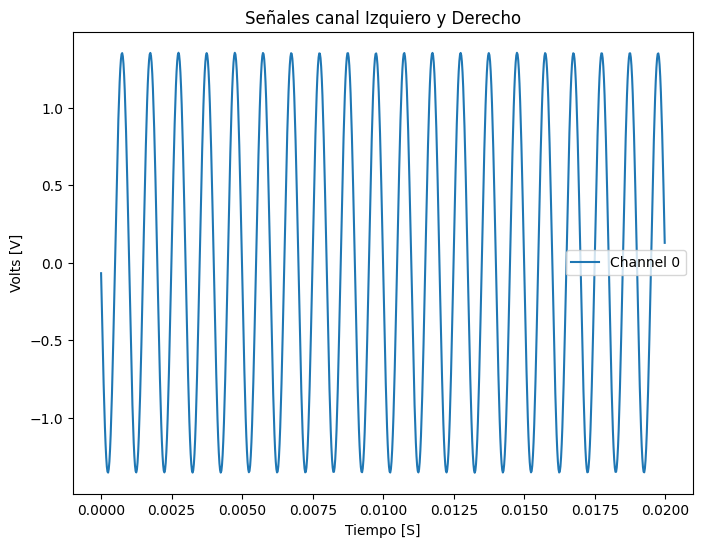

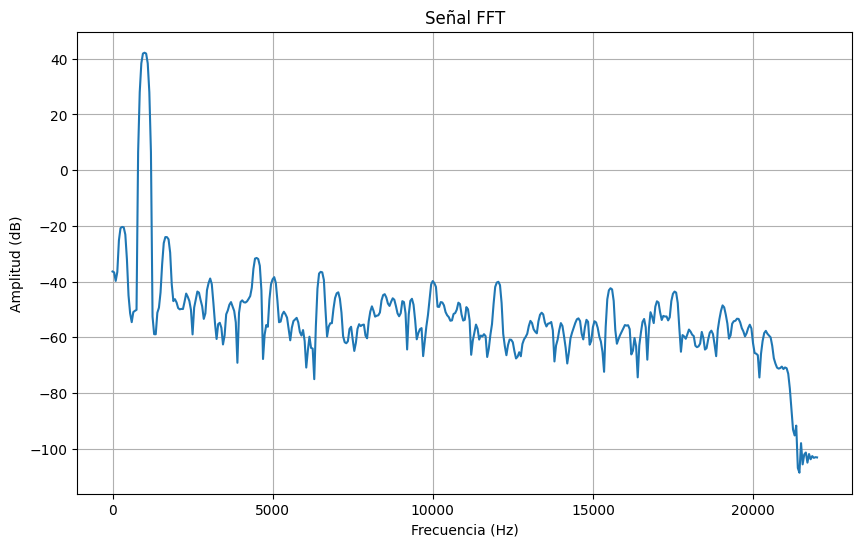

El pico de la FFT se encuentra en: 1000.0Hz con un valor de 42.186dB
El THD del canal 1 es de 0.008157630543996309%

Señal 1000Hz - 60LKFS


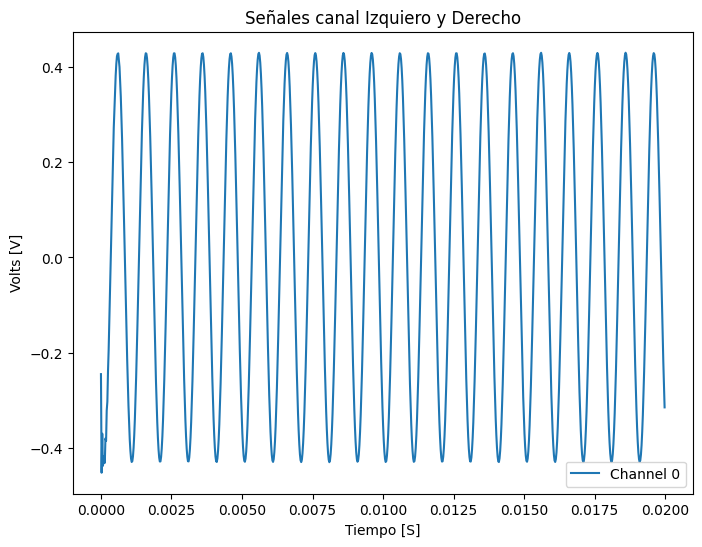

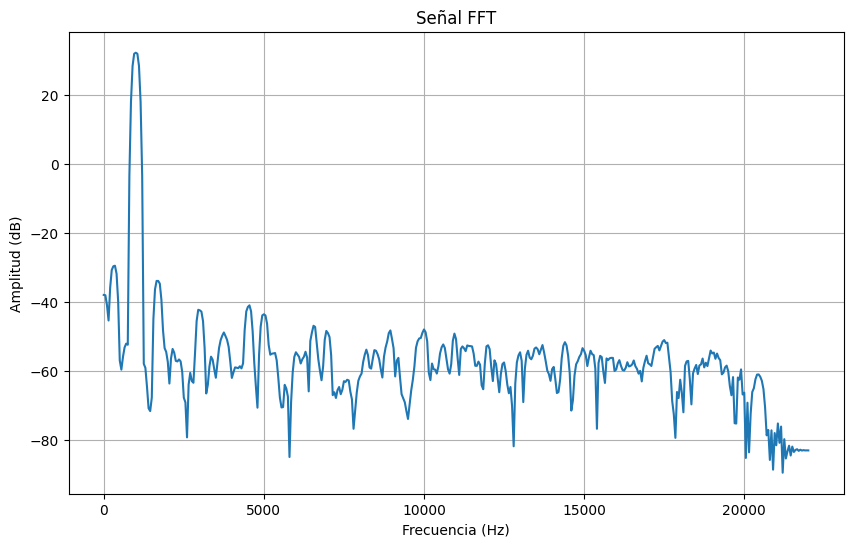

El pico de la FFT se encuentra en: 1000.0Hz con un valor de 32.214dB
El THD del canal 1 es de 0.3539170078921921%

Señal 1000Hz - 50LKFS


C:\Users\guido\AppData\Local\Temp\ipykernel_14200\936099974.py:4: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(nombre_archivo)


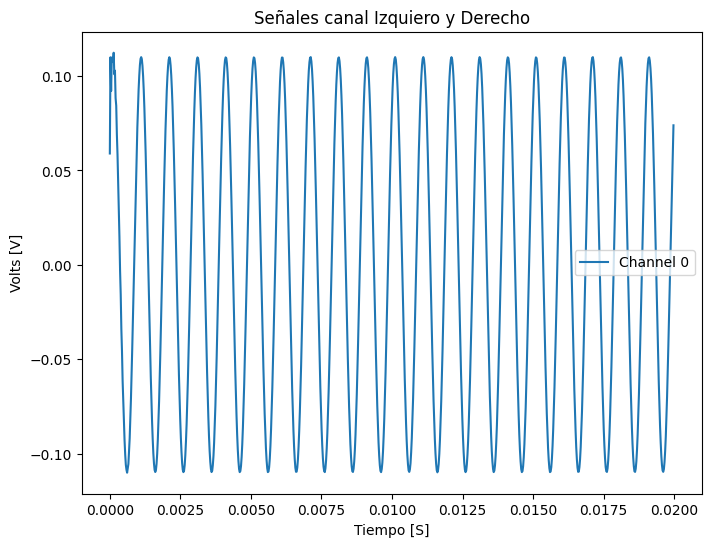

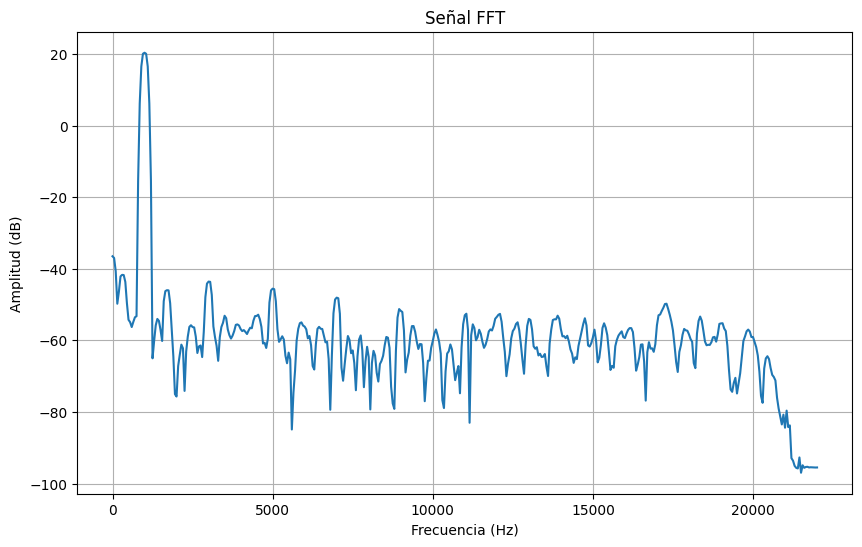

El pico de la FFT se encuentra en: 1000.0Hz con un valor de 20.371dB
El THD del canal 1 es de 0.33657280191555455%


In [113]:
archivos = ["./Mediciones-AnalizadorLogico/1000hz/1000hz_70lkfs.csv","./Mediciones-AnalizadorLogico/1000hz/1000hz_60lkfs.csv","./Mediciones-AnalizadorLogico/1000hz/1000hz_50lkfs.csv"]
nombre_medicion = ["Señal 1000 - 70LKFS","Señal 1000Hz - 60LKFS","Señal 1000Hz - 50LKFS"]
for this_archivo,this_nombre in zip(archivos,nombre_medicion):
    print(f"\n{this_nombre}")
    analizar_señales_analizador_logico(this_archivo)



Señal 10000 - 70LKFS


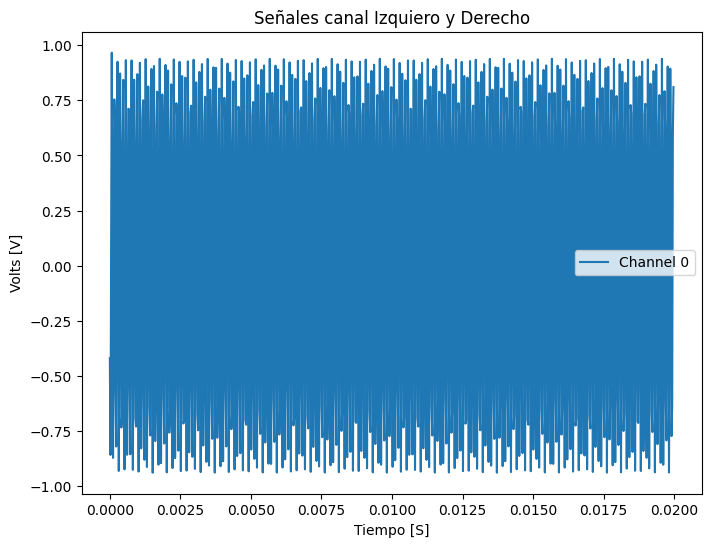

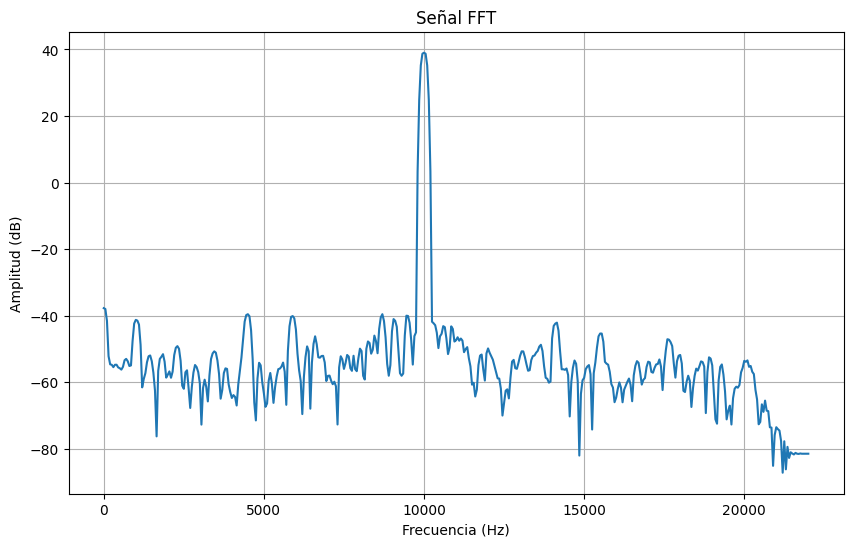

El pico de la FFT se encuentra en: 10000.0Hz con un valor de 39.001dB
El THD del canal 1 es de 0.05896052902887475%

Señal 10000Hz - 60LKFS


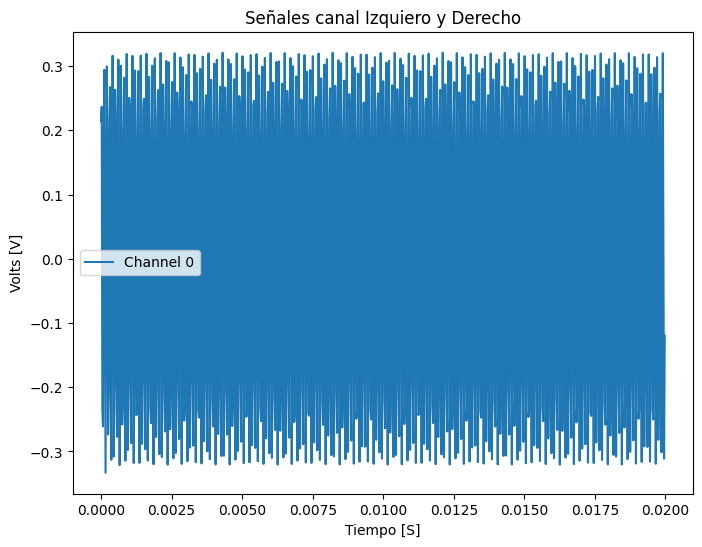

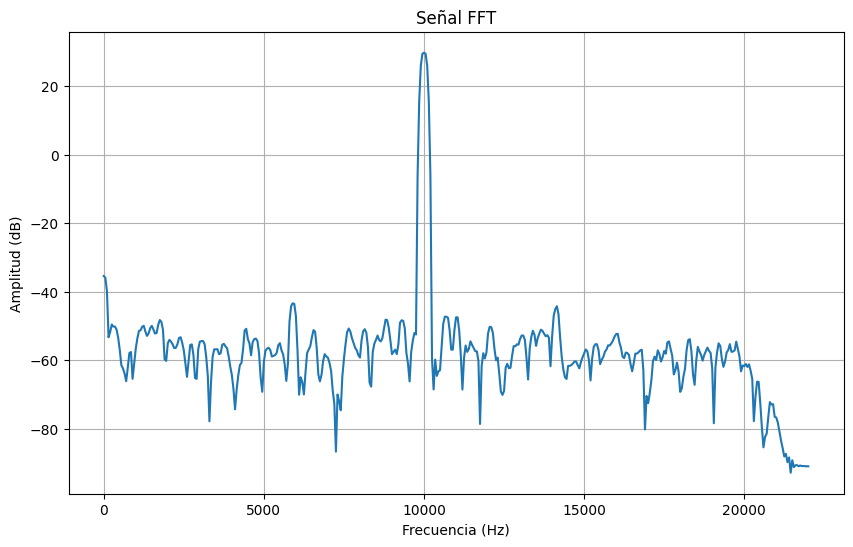

El pico de la FFT se encuentra en: 10000.0Hz con un valor de 29.664dB
El THD del canal 1 es de 0.12425681706231508%

Señal 10000Hz - 50LKFS


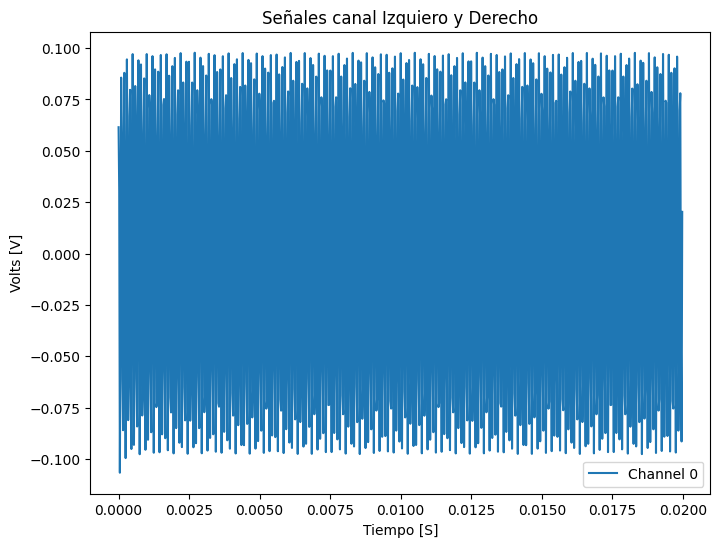

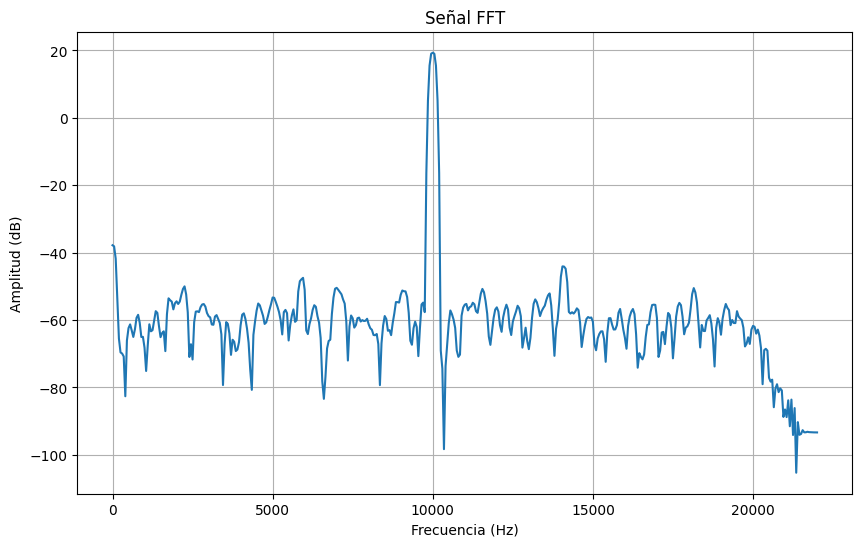

El pico de la FFT se encuentra en: 10000.0Hz con un valor de 19.333dB
El THD del canal 1 es de 0.2325939628475574%


In [114]:
archivos = ["./Mediciones-AnalizadorLogico/10000hz/10000hz_70lkfs.csv","./Mediciones-AnalizadorLogico/10000hz/10000hz_60lkfs.csv","./Mediciones-AnalizadorLogico/10000hz/10000hz_50lkfs.csv"]
nombre_medicion = ["Señal 10000 - 70LKFS","Señal 10000Hz - 60LKFS","Señal 10000Hz - 50LKFS"]
for this_archivo,this_nombre in zip(archivos,nombre_medicion):
    print(f"\n{this_nombre}")
    analizar_señales_analizador_logico(this_archivo)


# Mediciones señal de salida (señal amplificador)

A continuacion se muestran las señales medidas para cada caso en la salida del amplificador. Para todos los casos se muestran las señales de cada canal, la FFT de la diferencia entre ambos canales y se calcula el THD obtenido.


In [89]:

def analizar_señales(nombre_archivo):
    # Paso 1: Lee el archivo CSV
    df = pd.read_csv(nombre_archivo)

    # Paso 2: Recupero valores
    tiempo = df['x-axis'].to_numpy()
    canal1 = df['1'].to_numpy()
    canal2 = df['2'].to_numpy()
    tiempo = tiempo - tiempo[0]
    fMuestreo = len(tiempo)/tiempo[-1]
    
    #Elimino muestras vacías
    tiempo = tiempo[:-5]
    canal1 = canal1[:-5]
    canal2 = canal2[:-5]
    vdif = canal1-canal2
    
    plot_muestras(vdif, None, tiempo, "Señal Parlante - Sin filtrado")

    # Paso 3: Ploteo FFT señal obtenida
    plot_FFT(vdif,tiempo,"FFT - Señal Parlante - Sin filtrado")
    
    # Paso 4: Filtro señal portadora de 300kHz
    audioFiltrado = butter_lowpass_filter(vdif, 20000, fMuestreo)
    plot_muestras(audioFiltrado, None, tiempo, "Señal Parlante - Filtrada")

    # Paso 5: Ploteo FFT señal obtenida
    plot_FFT(audioFiltrado,tiempo,"FFT - Señal Parlante - Filtrada")
    plot_FFT(audioFiltrado,tiempo,"FFT - Señal Parlante - Filtrada", 20e3)
    

    # Paso 6: Calculo THD
    THD = get_THD(audioFiltrado)
    print(f"El THD de la señal es de {round(THD*100,2)}%")
    



### Señales de 500Hz


Señal 500Hz - 70LKFS


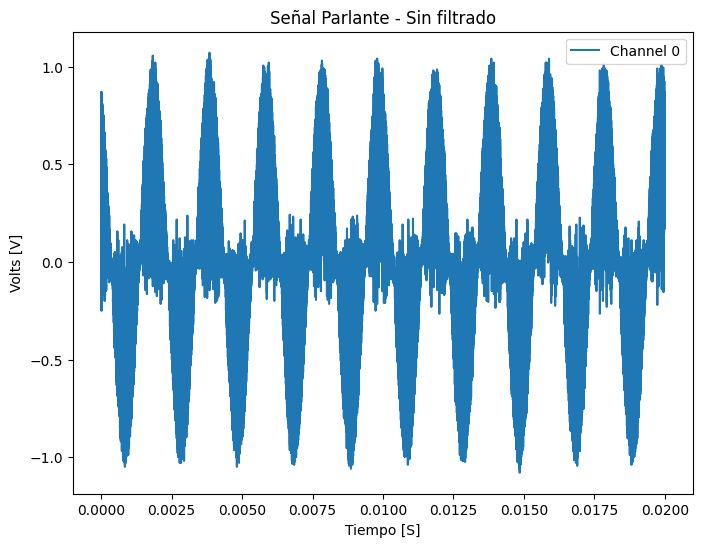

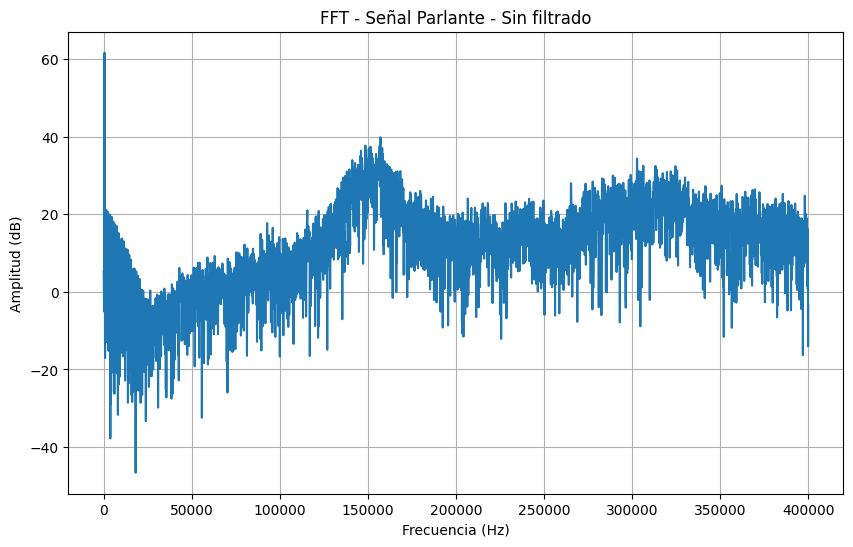

El pico de la FFT se encuentra en: 500.156Hz con un valor de 61.581dB


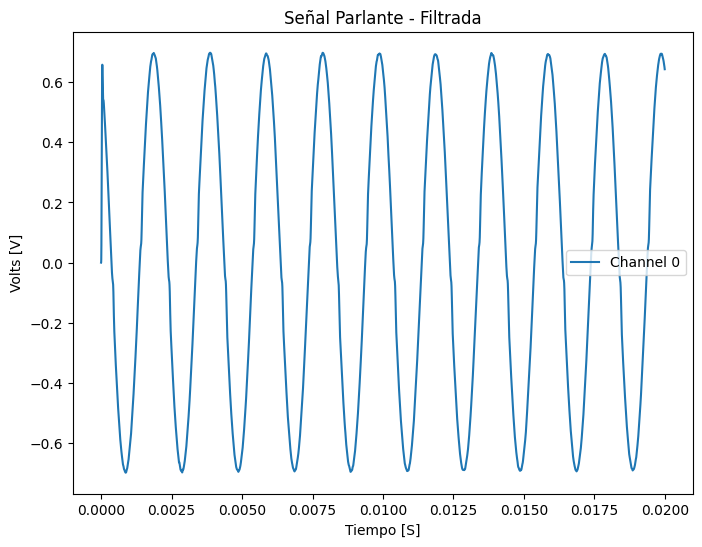

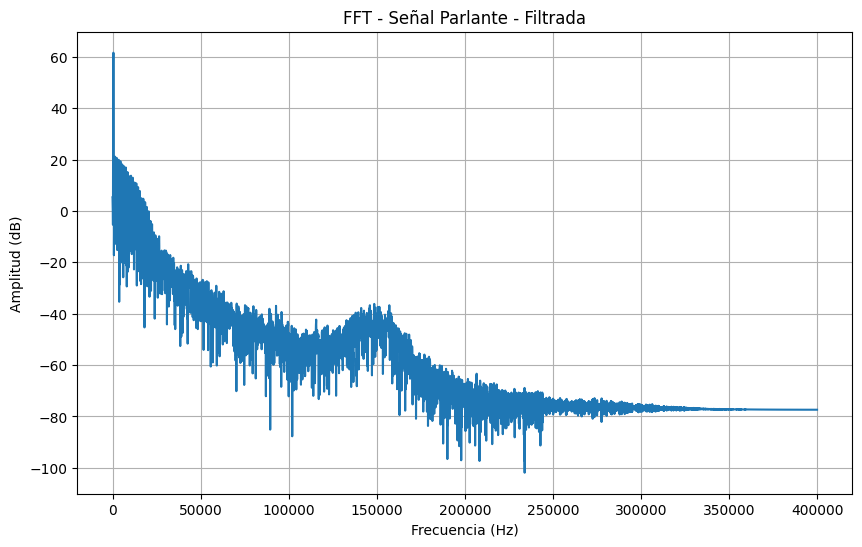

El pico de la FFT se encuentra en: 500.156Hz con un valor de 61.581dB


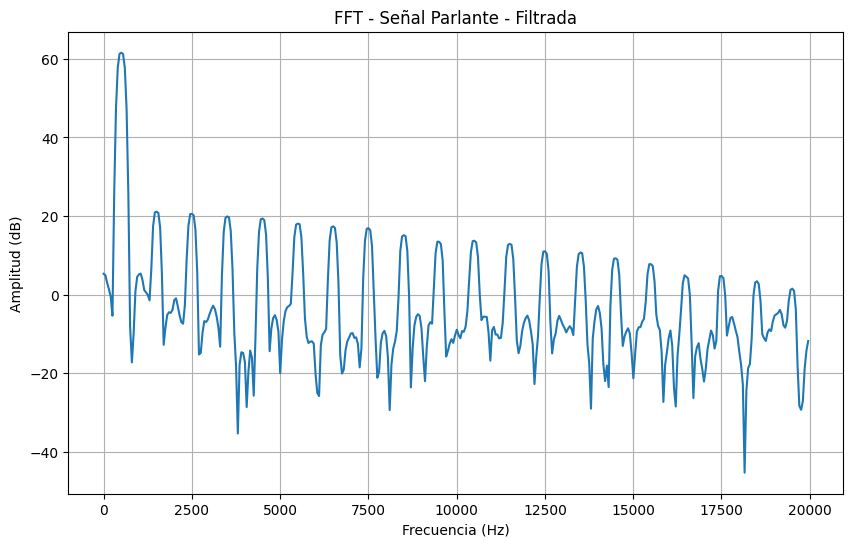

El pico de la FFT se encuentra en: 500.156Hz con un valor de 61.581dB
El THD de la señal es de 1.25%

Señal 500Hz - 60LKFS


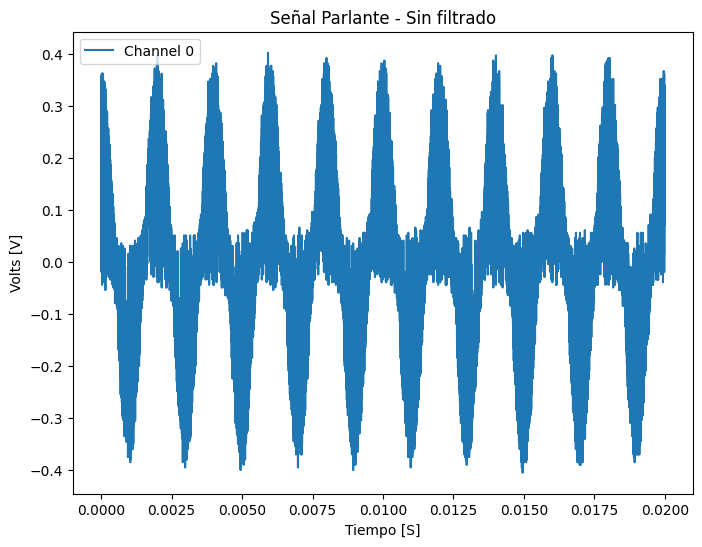

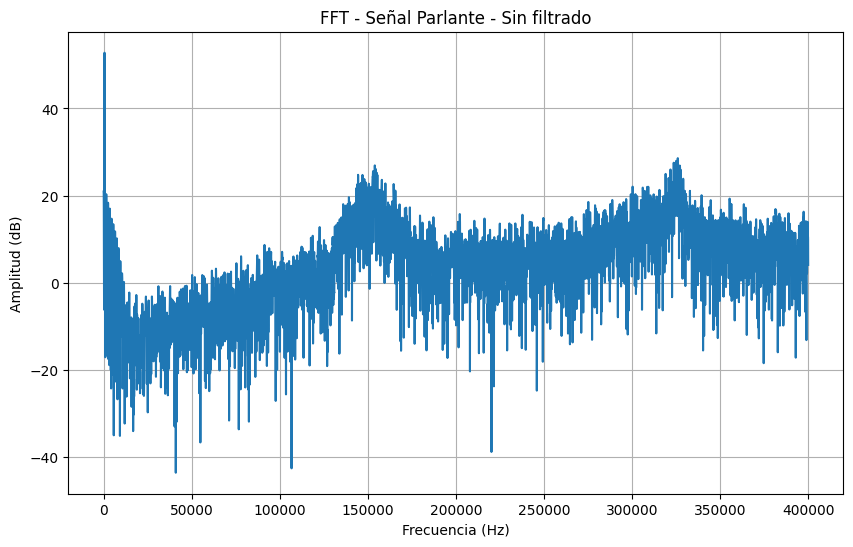

El pico de la FFT se encuentra en: 500.156Hz con un valor de 52.795dB


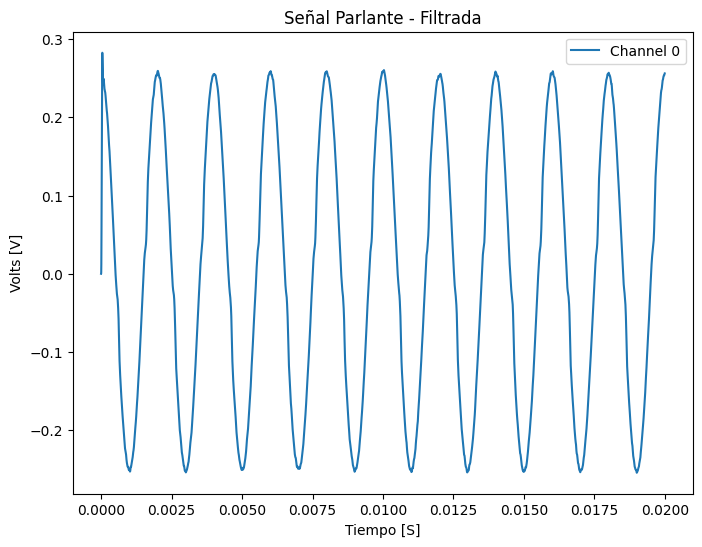

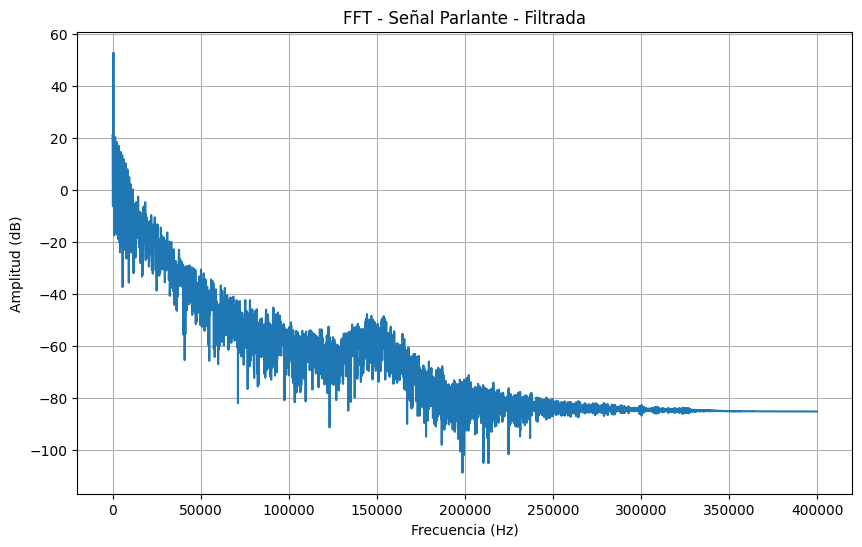

El pico de la FFT se encuentra en: 500.156Hz con un valor de 52.795dB


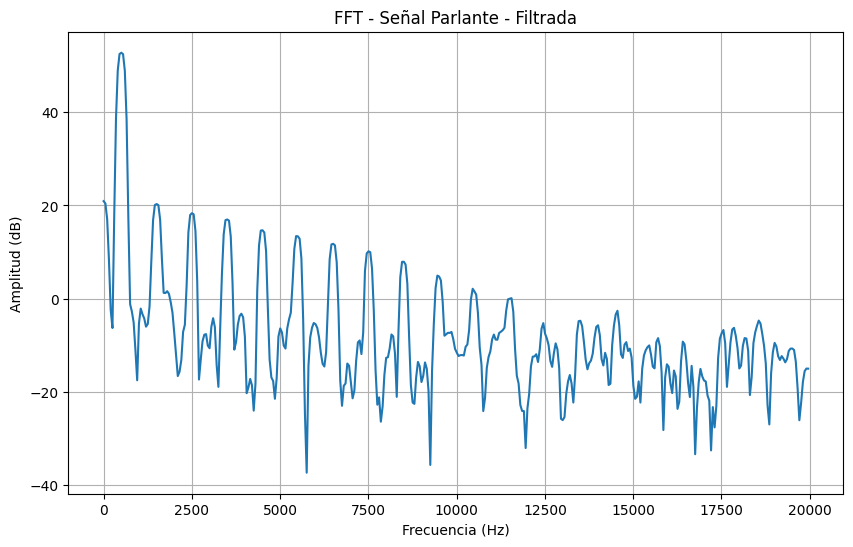

El pico de la FFT se encuentra en: 500.156Hz con un valor de 52.795dB
El THD de la señal es de 1.52%

Señal 500Hz - 50LKFS


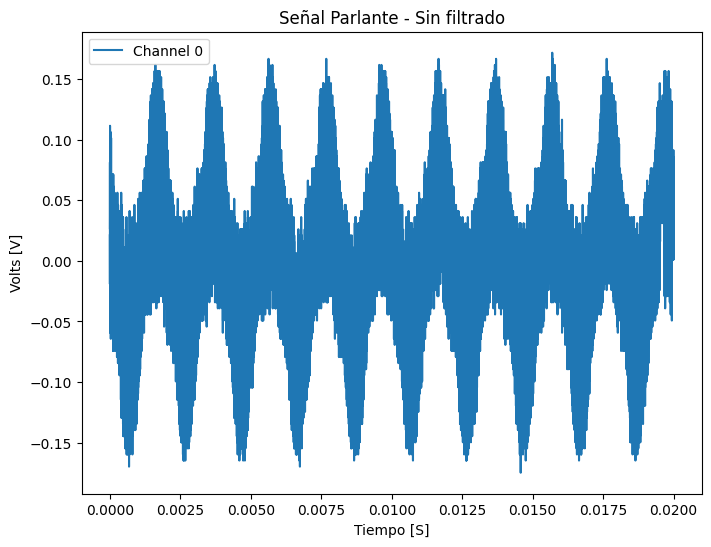

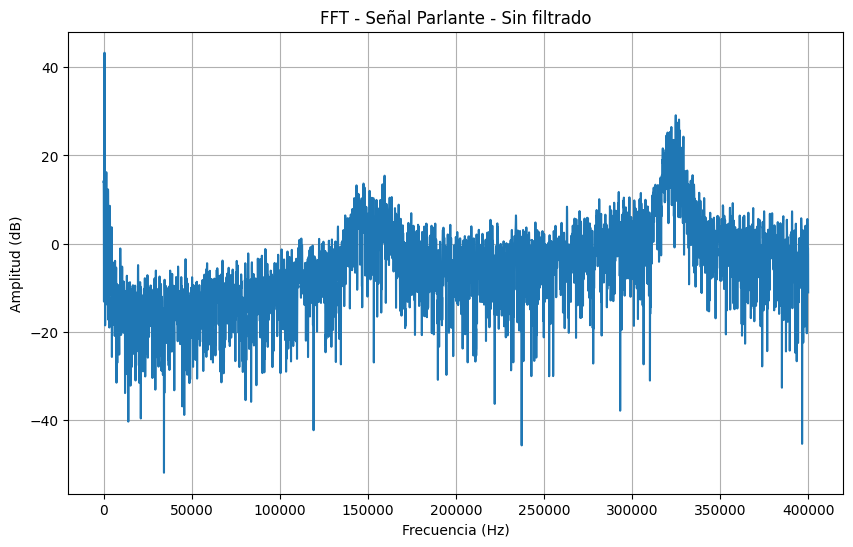

El pico de la FFT se encuentra en: 500.156Hz con un valor de 43.304dB


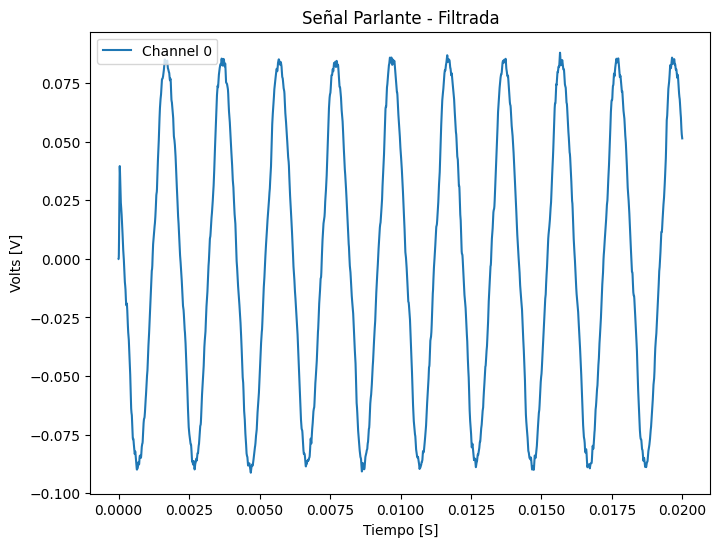

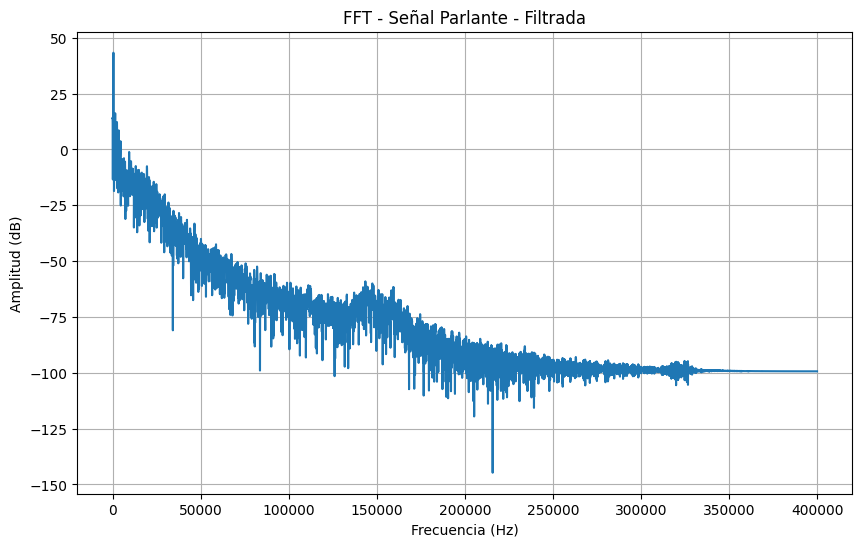

El pico de la FFT se encuentra en: 500.156Hz con un valor de 43.304dB


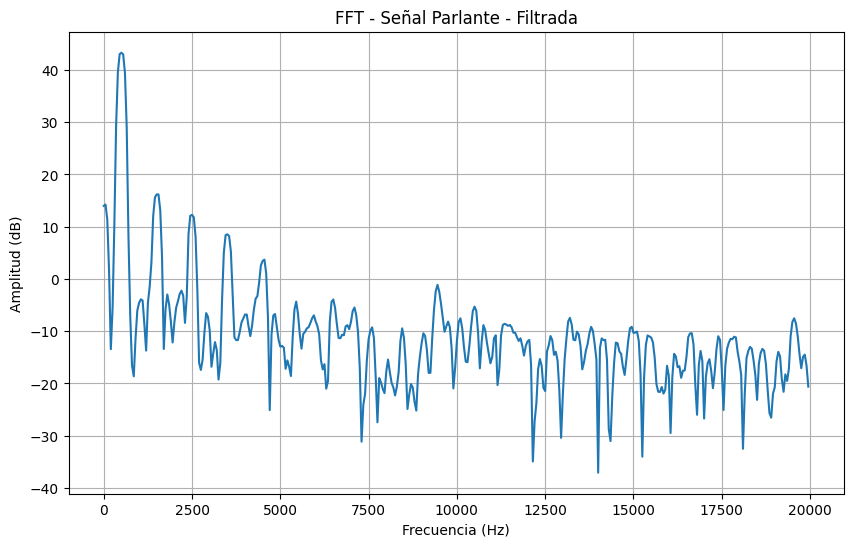

El pico de la FFT se encuentra en: 500.156Hz con un valor de 43.304dB
El THD de la señal es de 1.03%


In [63]:
archivos = ["./Mediciones-OSC/500hz/scope_34.csv","./Mediciones-OSC/500hz/scope_16.csv","./Mediciones-OSC/500hz/scope_18.csv"]
nombre_medicion = ["Señal 500Hz - 70LKFS","Señal 500Hz - 60LKFS","Señal 500Hz - 50LKFS"]
for this_archivo,this_nombre in zip(archivos,nombre_medicion):
    print(f"\n{this_nombre}")
    analizar_señales(this_archivo)



Señal 1000Hz - 70LKFS


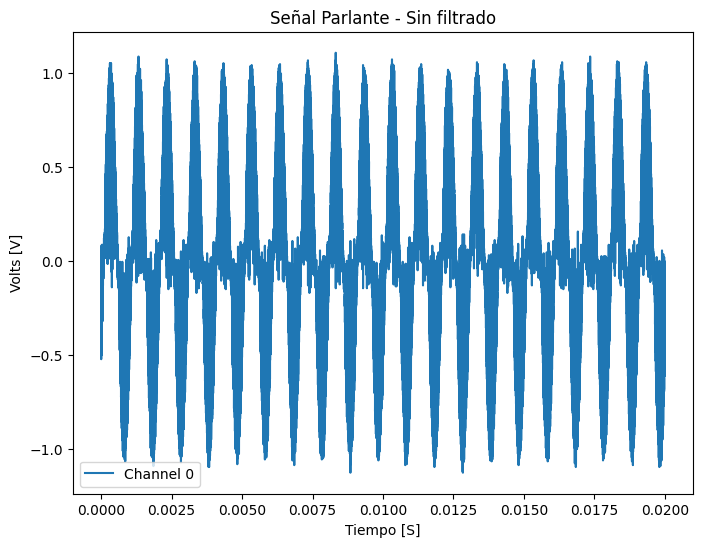

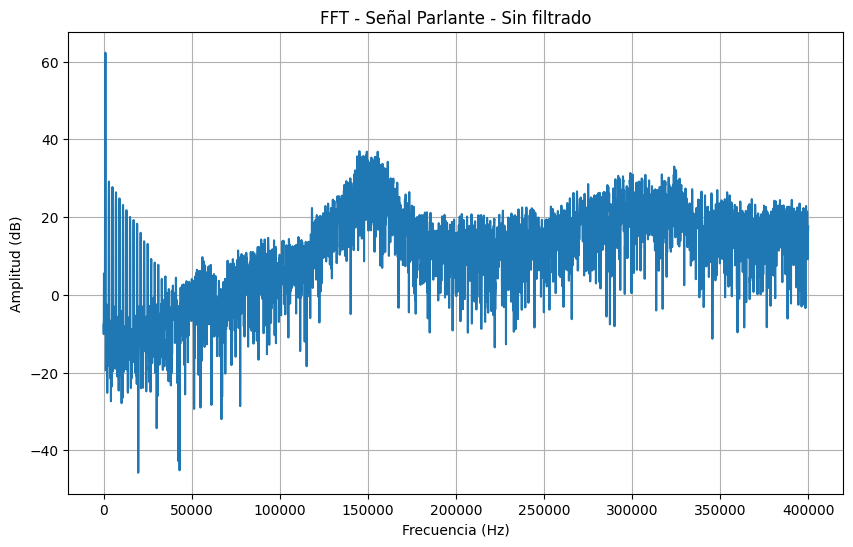

El pico de la FFT se encuentra en: 1000.313Hz con un valor de 62.278dB


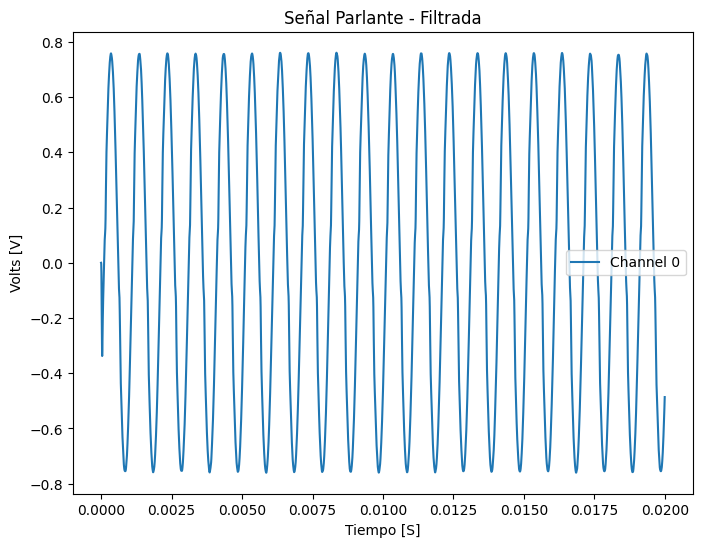

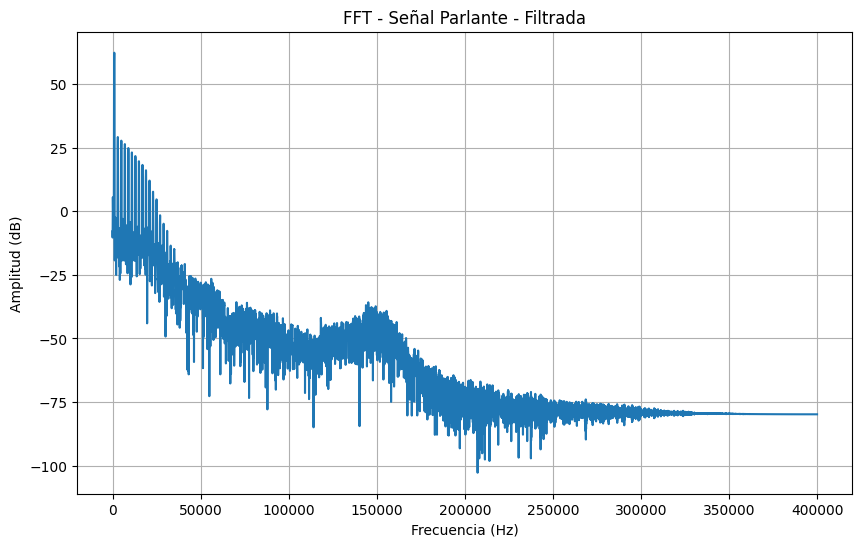

El pico de la FFT se encuentra en: 1000.313Hz con un valor de 62.278dB


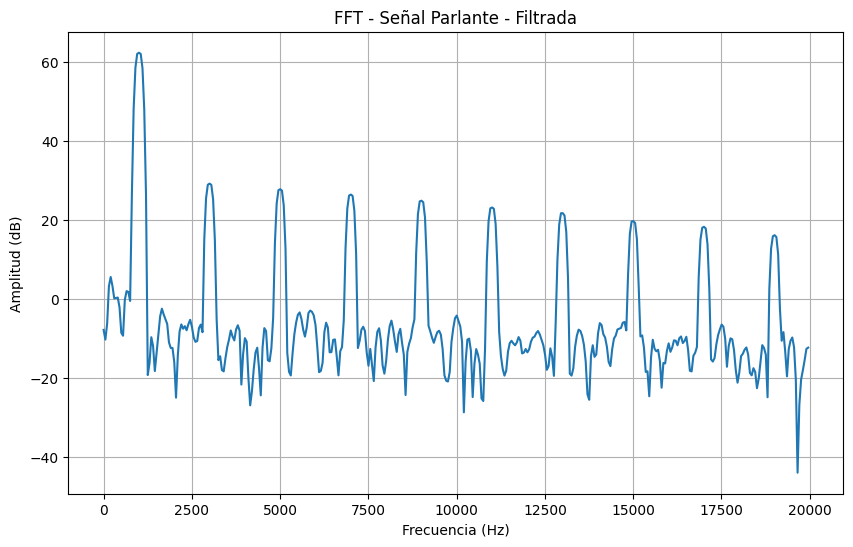

El pico de la FFT se encuentra en: 1000.313Hz con un valor de 62.278dB
El THD de la señal es de 0.56%

Señal 1000Hz - 60LKFS


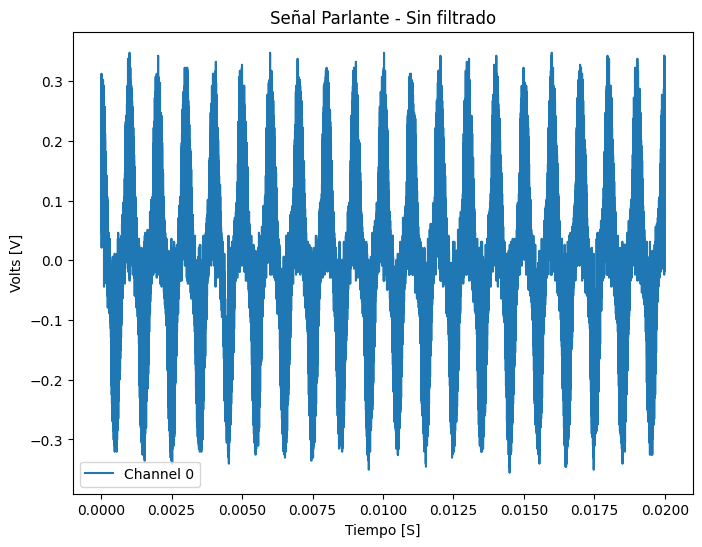

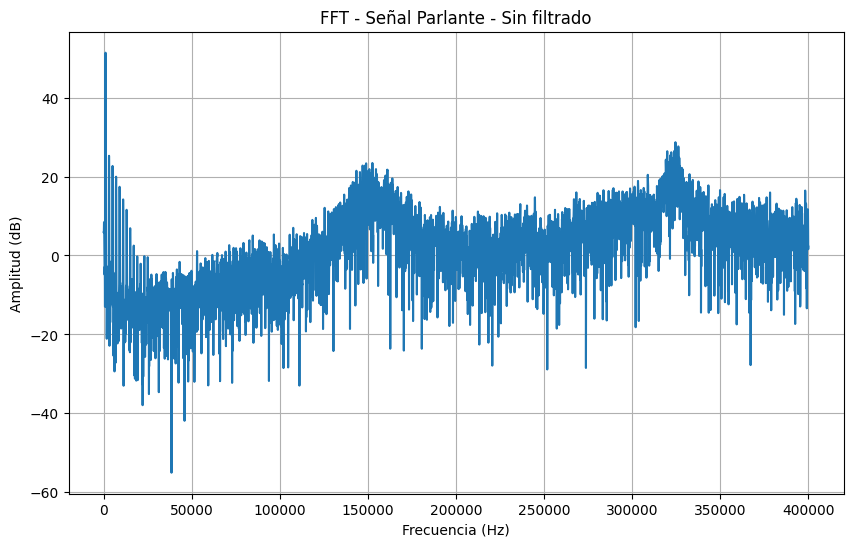

El pico de la FFT se encuentra en: 1000.313Hz con un valor de 51.38dB


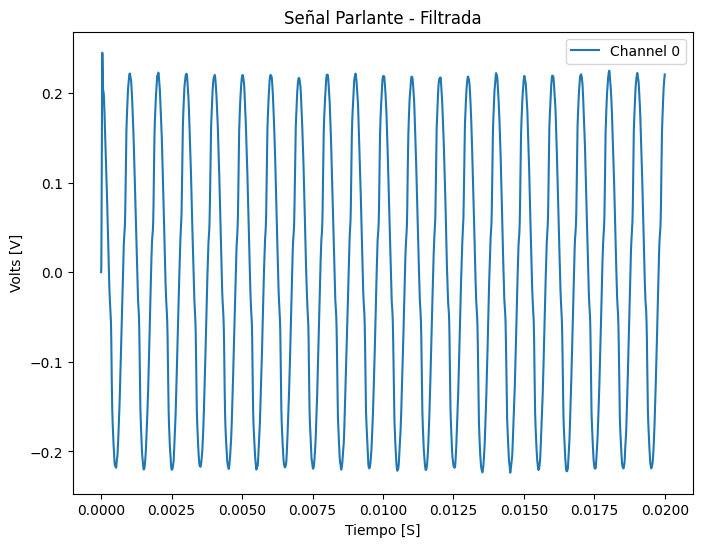

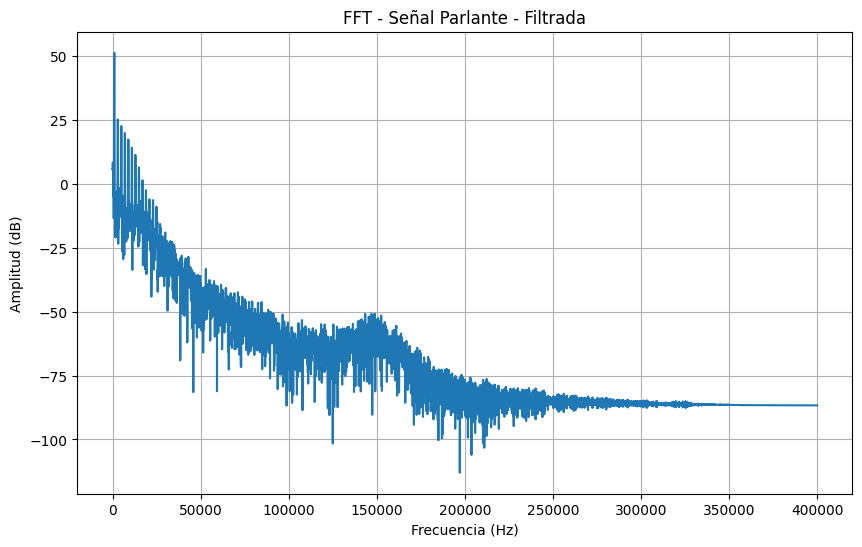

El pico de la FFT se encuentra en: 1000.313Hz con un valor de 51.38dB


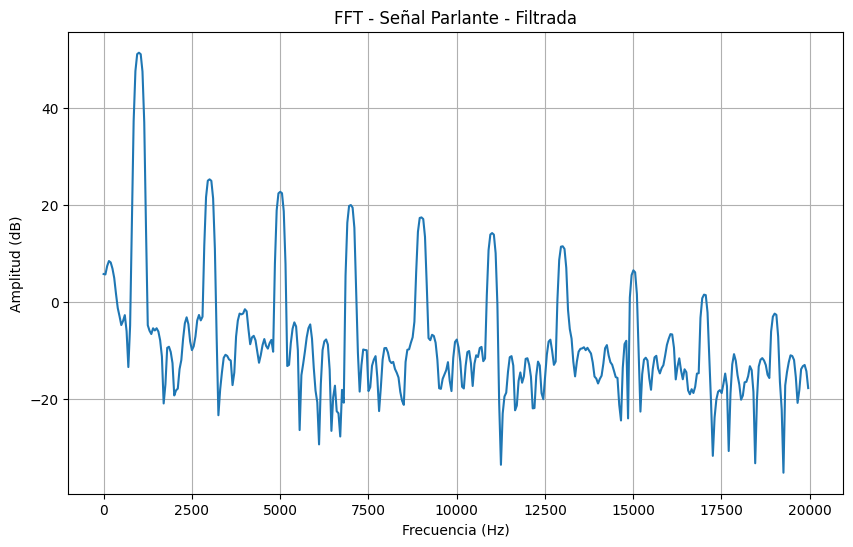

El pico de la FFT se encuentra en: 1000.313Hz con un valor de 51.38dB
El THD de la señal es de 0.97%

Señal 1000Hz - 50LKFS


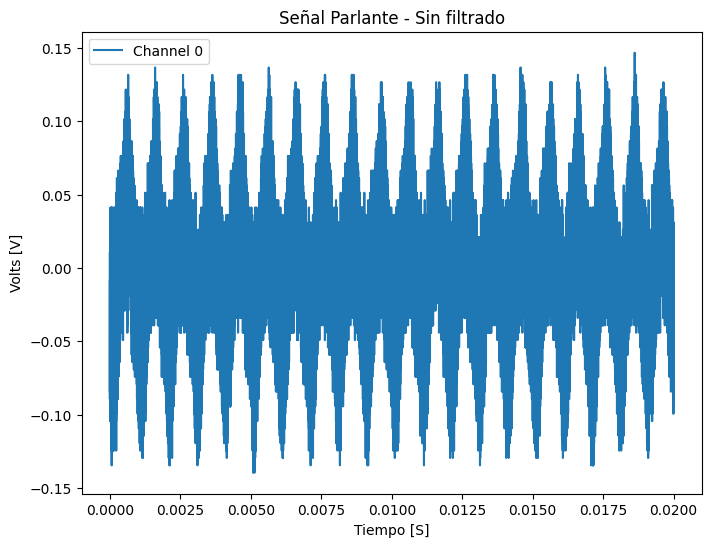

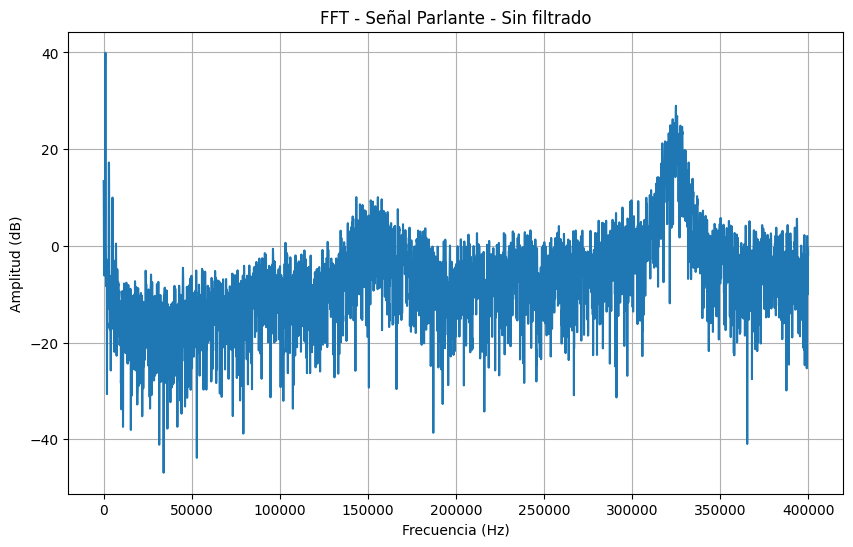

El pico de la FFT se encuentra en: 1000.313Hz con un valor de 39.934dB


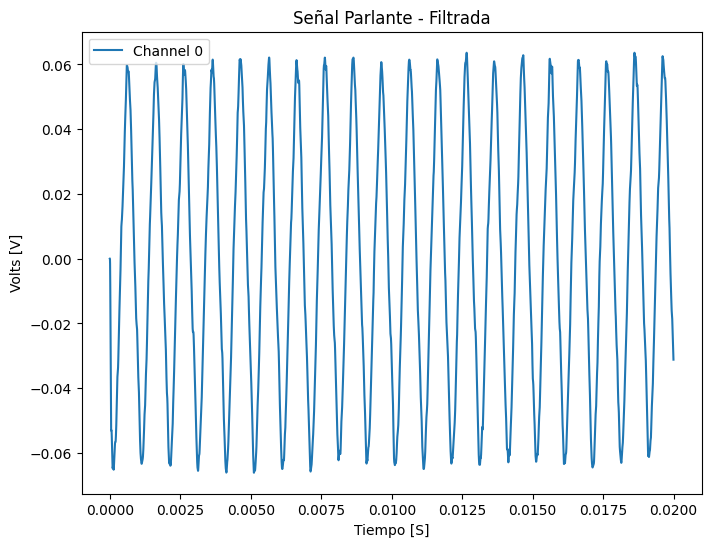

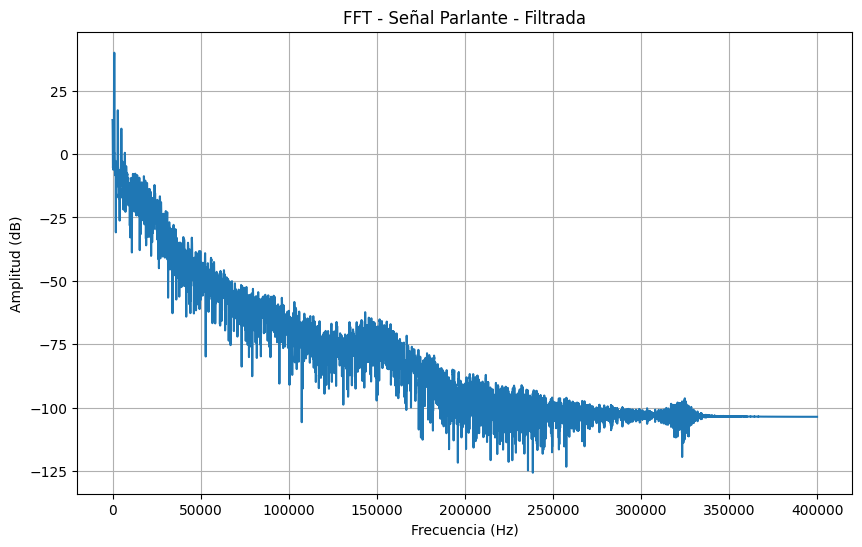

El pico de la FFT se encuentra en: 1000.313Hz con un valor de 39.933dB


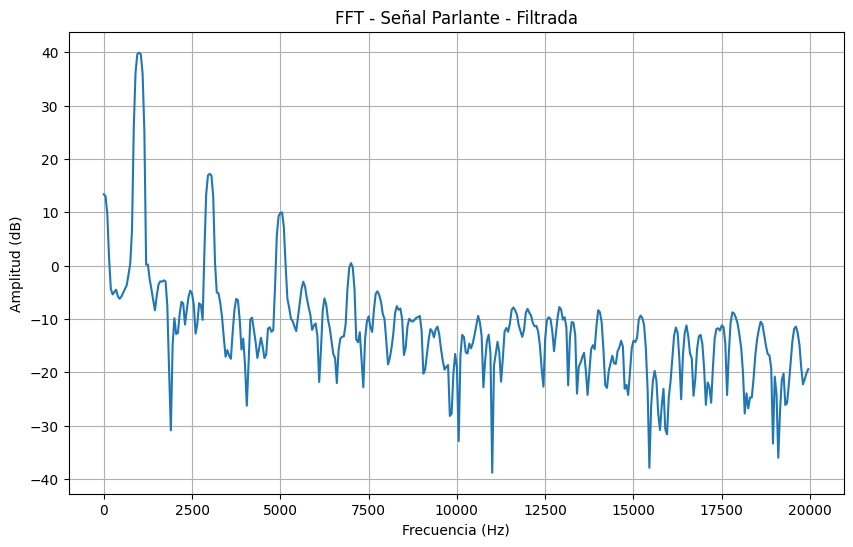

El pico de la FFT se encuentra en: 1000.313Hz con un valor de 39.933dB
El THD de la señal es de 0.9%


In [66]:
archivos = ["./Mediciones-OSC/1000hz/scope_20.csv","./Mediciones-OSC/1000hz/scope_22.csv","./Mediciones-OSC/1000hz/scope_26.csv"]
nombre_medicion = ["Señal 1000Hz - 70LKFS","Señal 1000Hz - 60LKFS","Señal 1000Hz - 50LKFS"]
for this_archivo,this_nombre in zip(archivos,nombre_medicion):
    print(f"\n{this_nombre}")
    analizar_señales(this_archivo)


Señal 10000Hz - 70LKFS


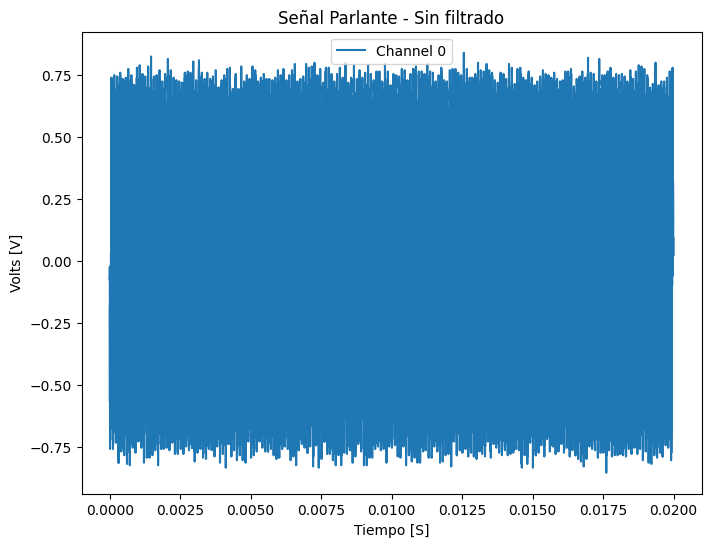

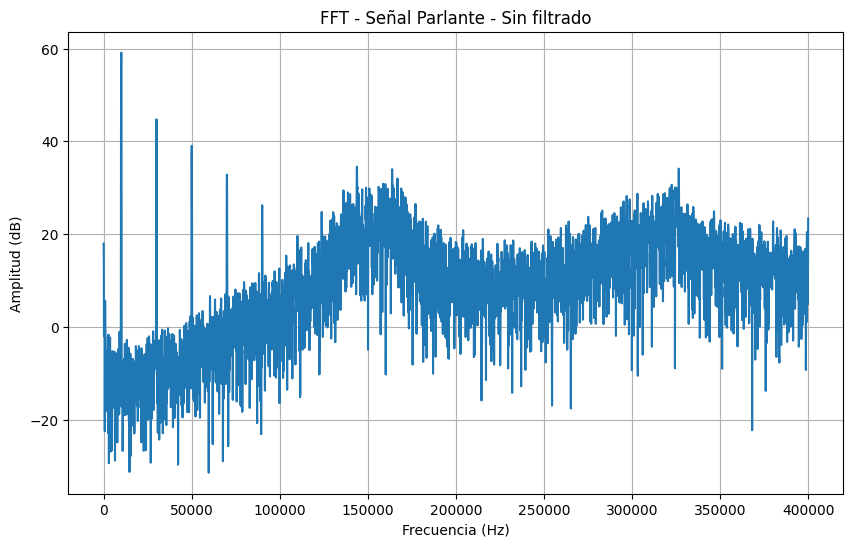

El pico de la FFT se encuentra en: 10003.126Hz con un valor de 59.095dB


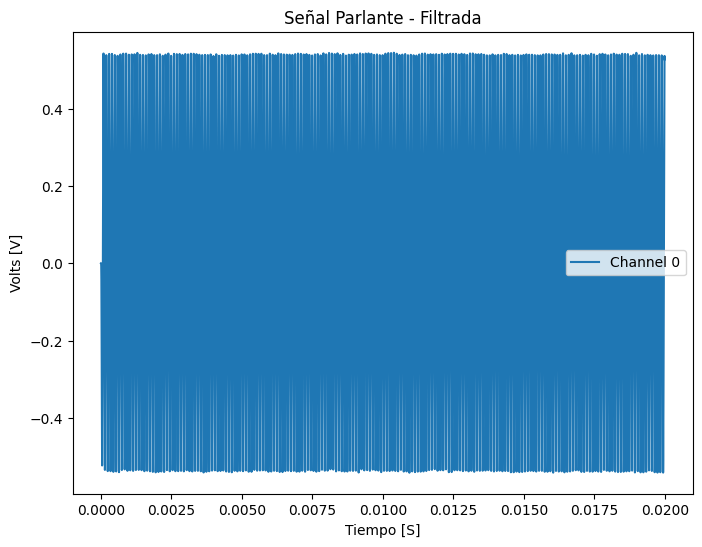

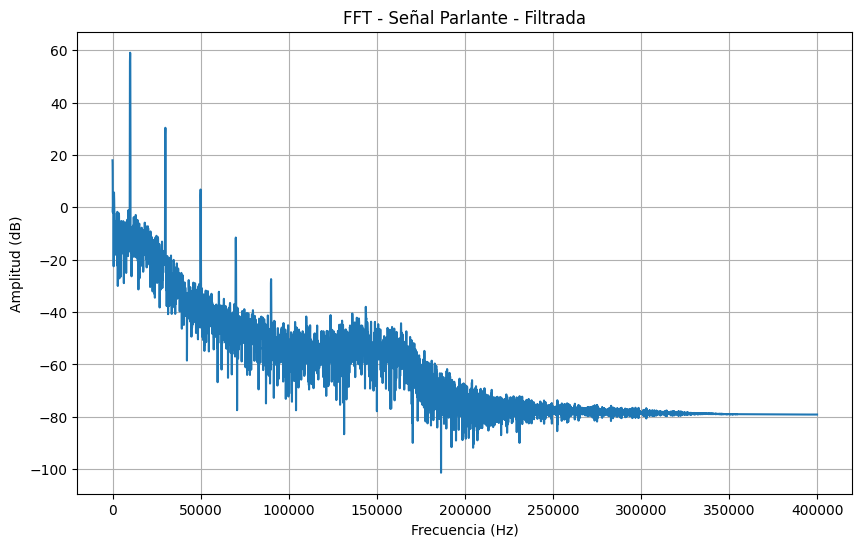

El pico de la FFT se encuentra en: 10003.126Hz con un valor de 59.078dB


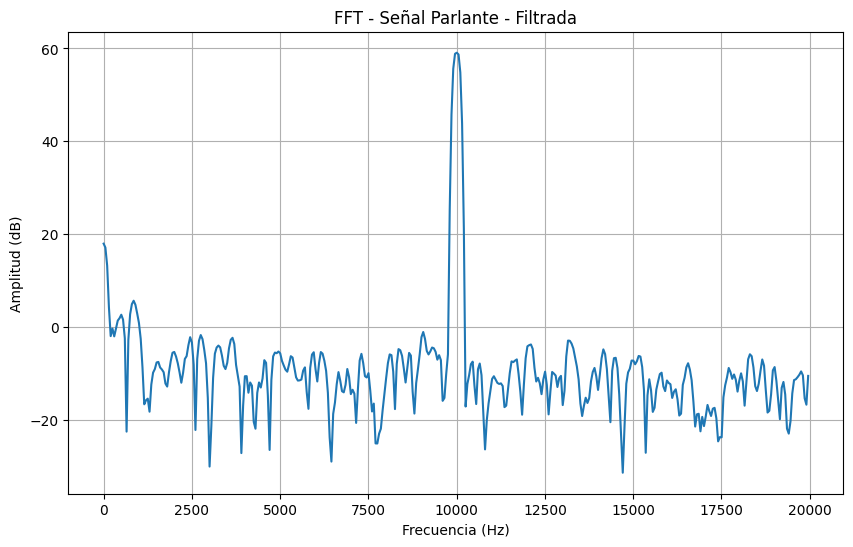

El pico de la FFT se encuentra en: 10003.126Hz con un valor de 59.078dB
El THD de la señal es de 0.33%

Señal 10000Hz - 60LKFS


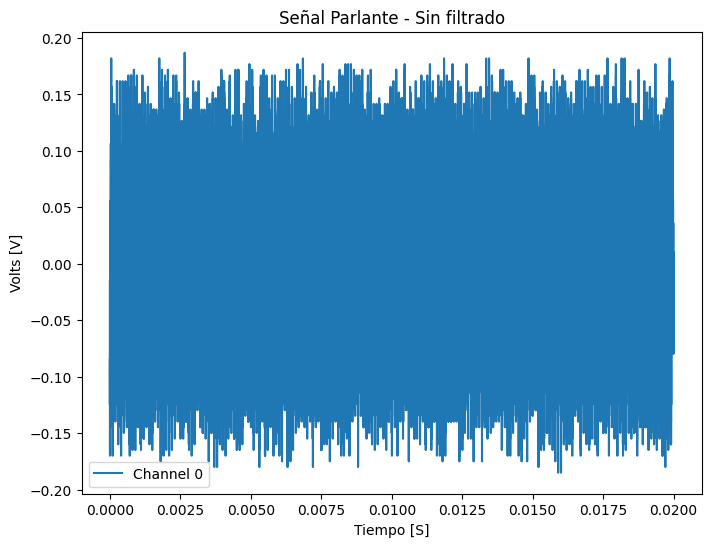

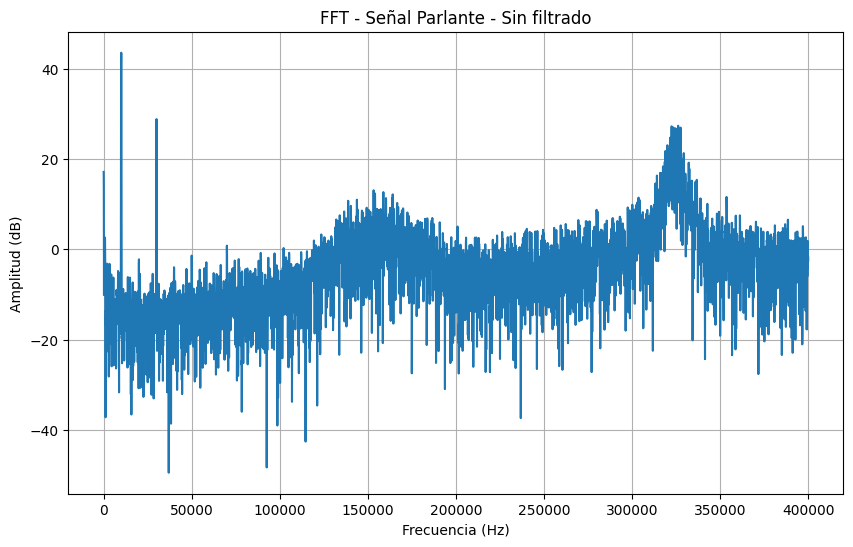

El pico de la FFT se encuentra en: 10003.126Hz con un valor de 43.508dB


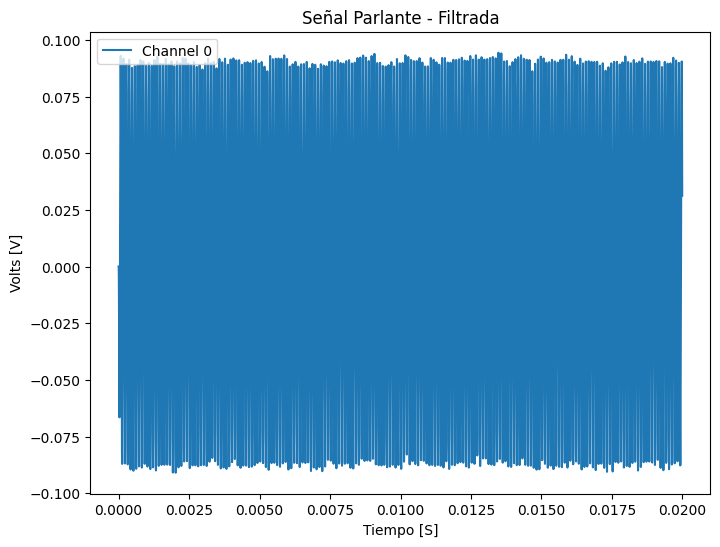

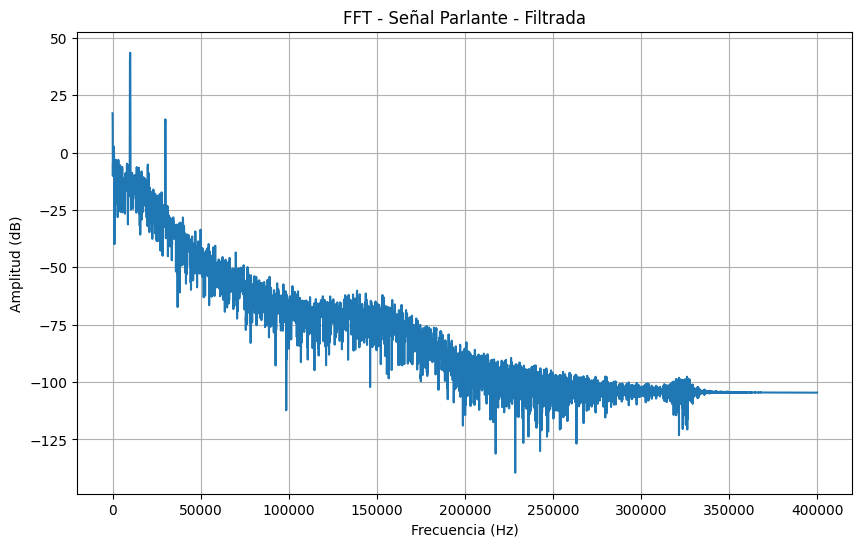

El pico de la FFT se encuentra en: 10003.126Hz con un valor de 43.491dB


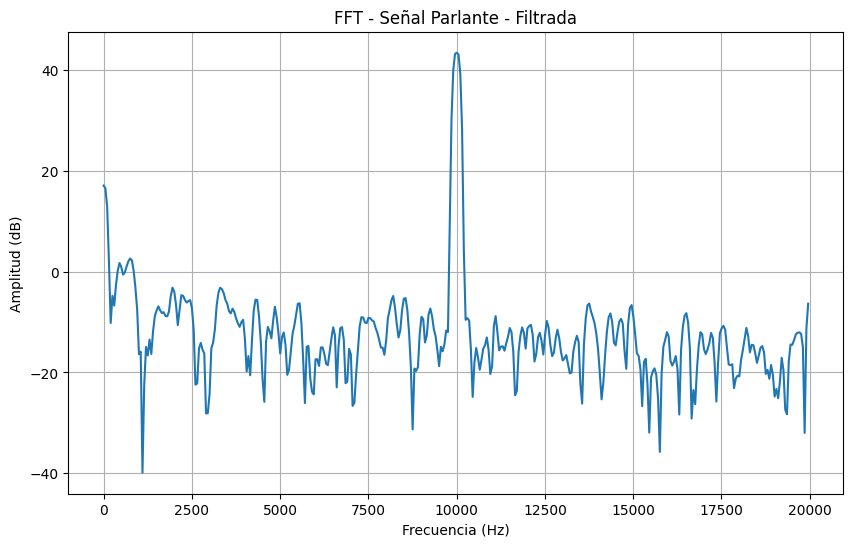

El pico de la FFT se encuentra en: 10003.126Hz con un valor de 43.491dB
El THD de la señal es de 0.33%

Señal 10000Hz - 50LKFS


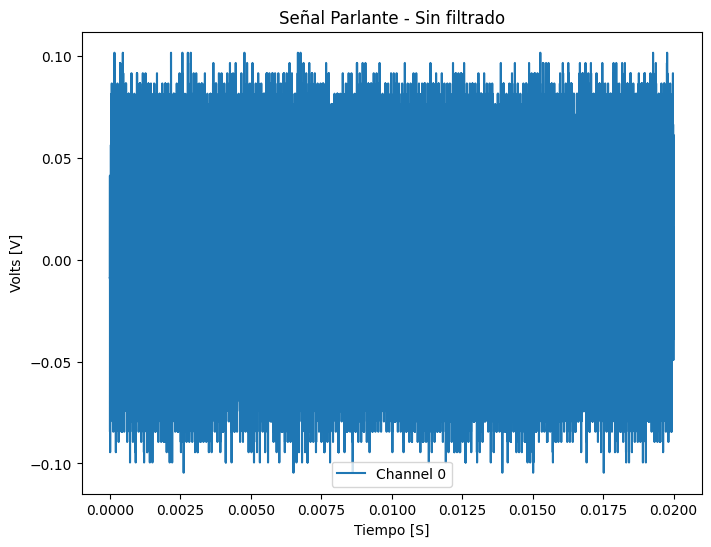

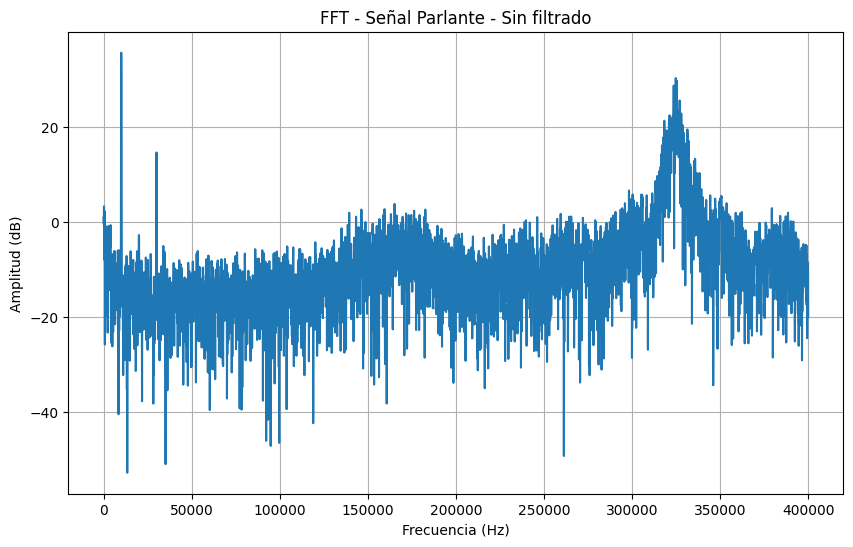

El pico de la FFT se encuentra en: 10003.126Hz con un valor de 35.58dB


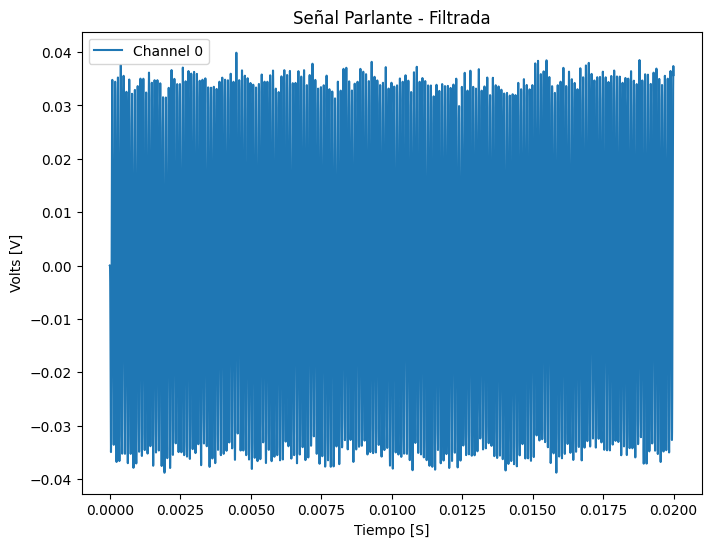

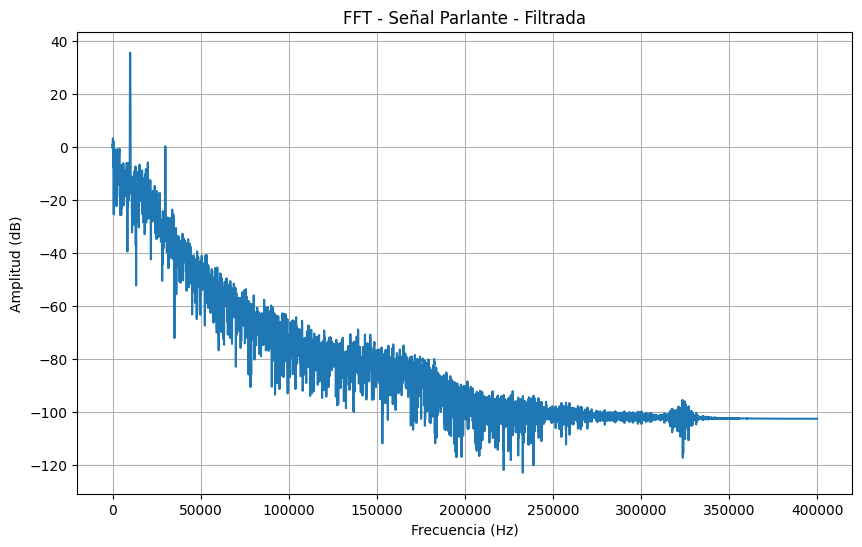

El pico de la FFT se encuentra en: 10003.126Hz con un valor de 35.563dB


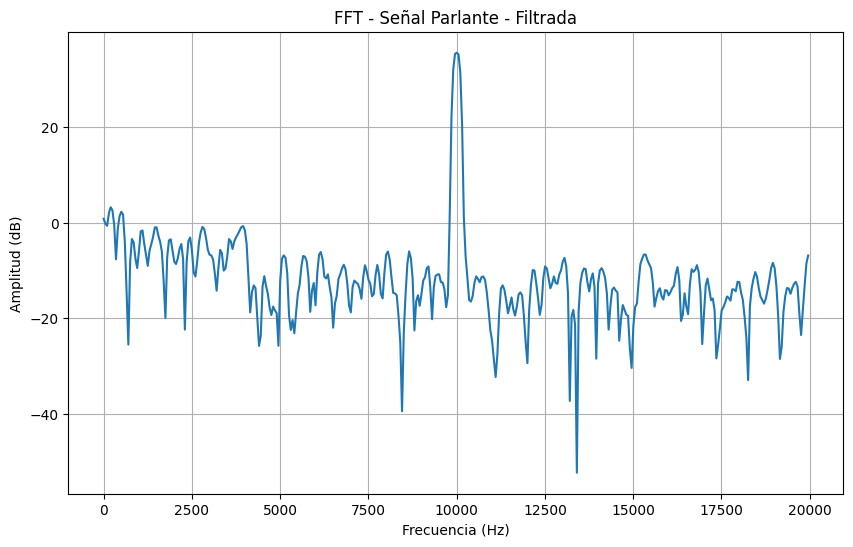

El pico de la FFT se encuentra en: 10003.126Hz con un valor de 35.563dB
El THD de la señal es de 0.22%


In [67]:
archivos = ["./Mediciones-OSC/10000hz/scope_28.csv","./Mediciones-OSC/10000hz/scope_30.csv","./Mediciones-OSC/10000hz/scope_32.csv"]
nombre_medicion = ["Señal 10000Hz - 70LKFS","Señal 10000Hz - 60LKFS","Señal 10000Hz - 50LKFS"]
for this_archivo,this_nombre in zip(archivos,nombre_medicion):
    print(f"\n{this_nombre}")
    analizar_señales(this_archivo)

## Tabla comparativa


A continuacion se muestran los resultados obtenidos en las mediciones.
Los resultados que se muestran son:
- THD% ESP: es la distorcion que se mide a la salida del ESP32 causada tanto por la transmicion Bluetooth y el procesamiento interno del microcontrolador. Esta medicion se obtiene sobre una señal digital por medio del analizador logico
- THD% Salida: es la distocion que se mide a la salida del sistema. En este valor esta contenida la distorcion de todo el sistema (bluetooth, ESP32, procesamiento, amplificador)
- THD% Amp: es la distorcion causada por el amplificador. Este valor se obtiene de las dos mediciones previas

<table>
<thead>
  <tr>
    <th rowspan="2">Parametro</th>
    <th colspan="3">Señal 500Hz</th>
    <th colspan="3">Señal 1KHz</th>
    <th colspan="3">Señal 10KHz</th>
  </tr>
  <tr>
    <th>70LKFS</th>
    <th>60LKFS</th>
    <th>50LKFS</th>
    <th>70LKFS</th>
    <th>60LKFS</th>
    <th>50LKFS</th>
    <th>70LKFS</th>
    <th>60LKFS</th>
    <th>50LKFS</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td>THD % - ESP32</td>
    <td></td>
    <td></td>
    <td></td>
    <td></td>
    <td></td>
    <td></td>
    <td></td>
    <td></td>
    <td></td>
  </tr>
  <tr>
    <td>THD % - Salida</td>
    <td>1,25%</td>
    <td>1,52%</td>
    <td>1.03%</td>
    <td>0.56%</td>
    <td>0.97%</td>
    <td>0.9%</td>
    <td>0.33%</td>
    <td>0.33%</td>
    <td>0.22%</td>
  </tr>
  <tr>
    <td>THD % - Amp</td>
    <td></td>
    <td></td>
    <td></td>
    <td></td>
    <td></td>
    <td></td>
    <td></td>
    <td></td>
    <td></td>
  </tr>
</tbody>
</table>